# Library

In [11]:
import os
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans 
import xgboost as xgb
from datetime import datetime  
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_log_error


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.metrics import r2_score
from statistics import stdev
from statistics import mean
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score



# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras import losses
# from keras import optimizers
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from keras.utils import plot_model
# from keras.models import load_model
# import keras.backend as K
# import tensorflow as tf


import os
from math import radians, cos, sin, asin, sqrt, log
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


# Function

In [5]:
# define my own custom loss function
def rmsle_loss(y_pred, y_true): 
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    y_true = tf.convert_to_tensor(y_true, np.float32)
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

# define my own custom score function
def rmsle(y_true, y_pred):
    y_pred = list(map(lambda x:x if x>0 else 0.000001, y_pred))
    first_log = np.log(y_pred)
    second_log = np.log(y_true)
    return np.sqrt(np.mean(np.square(first_log - second_log)))
rmsle_socre = make_scorer(rmsle, greater_is_better=False)

def create_model(input_dim = 73, nodes_num=[256]):
    n = len(nodes_num)
    # create model
    model = Sequential()
    for i in range(n):
        if i == 0:
            model.add(Dense(nodes_num[i], input_dim=input_dim, activation='relu', kernel_initializer='normal'))
        else :
            model.add(Dense(nodes_num[i], activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=losses.mean_squared_logarithmic_error, optimizer='adam', metrics=[rmsle_loss])
    return model

# using GridSearchCv to find proper parameters
def My_GridSearchCV(grid_params, X, Y):
    # create model
    model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=50, verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=grid_params, cv=3, scoring = rmsle_socre, verbose=10)
    grid_result = grid.fit(X, Y)
    return grid_result

# summarize grid reseach cv results
def Summary_GridResult(grid_result):
    # grid_result.cv_results_
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, std, param in zip(means, stds, params):
        print("mean: %f, std: %f, with: %r" % (mean, std, param))    
    



def load_data(path) :
    data = pd.read_csv(path) 
    # basic data cleaning. drop useless columns
    data.loc[data.Parallel_Distance.isnull(), 'Parallel_Distance'] = data[data['Parallel_Distance'].isnull()]['distance_in_km'].values
    data = data.drop(['date_of_year','date_of_year2','mo','da'], axis=1)
    return (data)

def extract_time (data):
    data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)  
    data.loc[:,'pickup_day'] =  data['pickup_datetime'].dt.day
    data.loc[:,'pickup_month'] =  data['pickup_datetime'].dt.month
    data.loc[:,'pickup_hour'] =  data['pickup_datetime'].dt.hour
    data.loc[:,'pickup_weekday'] =  data['pickup_datetime'].dt.weekday+1
    data.loc[:,'log_travel_time'] =  np.log(data['travel_time'].values+1)
    
    return(data)

def add_avg_speed(data, group,name) :
    avg_speed = pd.DataFrame(data.groupby(group)['speed'].mean())
    avg_speed = avg_speed_h.rename(columns={'speed':name})
    return (avg_speed)

# Transfrom categorical variables into dummy variables using one hot encode
def dummy_one_hot (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    cluster_pickup = pd.get_dummies(data['pickup_cluster'], prefix='p', prefix_sep='_')  
    cluster_dropoff = pd.get_dummies(data['dropoff_cluster'], prefix='d', prefix_sep='_')  
    #month = pd.get_dummies(data['pickup_month'], prefix='m', prefix_sep='_')   
    dom = pd.get_dummies(data['pickup_day'], prefix='dom', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_')  
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_month','pickup_day','pickup_hour','pickup_weekday',  
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime', 
                              'trip_distance','travel_time','speed'], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  
                          passenger_count,
                          cluster_pickup,
                          cluster_dropoff,
                          dom, hour, dow], axis=1)
    
    return(data)

def col_consistant(data,cluster_num):
    cluster = range(1,cluster_num,1)
    cluster_dummy_p = pd.get_dummies(cluster, prefix='p', prefix_sep='_')  
    cluster_dummy_d = pd.get_dummies(cluster, prefix='d', prefix_sep='_')  
    cluster_dummy = pd.concat([cluster_dummy_p, cluster_dummy_d], axis=1)
    passenger = range(1,9,1)
    passenger_dummy = pd.get_dummies(passenger, prefix='pc', prefix_sep='_') 
    whole = pd.concat([cluster_dummy, passenger_dummy], axis=1)
    # let two dataset has the same columns
    larger_colnames = whole.columns.values.tolist()
    smaller_colnames = data.columns.values.tolist()
    ret = list(set(larger_colnames).difference(set(smaller_colnames)))
    d = pd.DataFrame(0, index=np.arange(data.shape[0]), columns=ret)
    data = pd.concat([data,  
                          d], axis=1)
    return(data)

def dummy_one_hot1 (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    dom = pd.get_dummies(data['pickup_day'], prefix='dom', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_')  
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_month','pickup_day','pickup_hour','pickup_weekday',  
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime', 
                              'trip_distance','log_travel_time','speed'], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  
                          passenger_count,
                          dom, hour, dow], axis=1)
    
    return(data)

def col_consistant1(data):
   
    passenger = range(1,9,1)
    passenger_dummy = pd.get_dummies(passenger, prefix='pc', prefix_sep='_') 
    # let two dataset has the same columns
    larger_colnames = passenger_dummy.columns.values.tolist()
    smaller_colnames = data.columns.values.tolist()
    ret = list(set(larger_colnames).difference(set(smaller_colnames)))
    d = pd.DataFrame(0, index=np.arange(data.shape[0]), columns=ret)
    data = pd.concat([data,  
                          d], axis=1)
    return(data)

def modelcompare(xgb,bp,dtree,lasso):
    rmsle = pd.DataFrame([np.sqrt(mean_squared_log_error(xgb["log_travel_time"], xgb["predictions-XGB"])),
          np.sqrt(mean_squared_log_error(bp["true_value"], bp["predictions-BPNN"])),
          np.sqrt(mean_squared_log_error(dtree["travel_time"], dtree["predictions-decistion tree"])),
          np.sqrt(mean_squared_log_error(lasso["travel_time"], lasso["predictions-lasso"]))])
    rmse = pd.DataFrame([np.sqrt(mean_squared_error(xgb["log_travel_time"], xgb["predictions-XGB"])),
          np.sqrt(mean_squared_error(bp["true_value"], bp["predictions-BPNN"])),
          np.sqrt(mean_squared_error(dtree["travel_time"], dtree["predictions-decistion tree"])),
          np.sqrt(mean_squared_error(lasso["travel_time"], lasso["predictions-lasso"]))])
    r2 = pd.DataFrame([r2_score(xgb["log_travel_time"], xgb["predictions-XGB"]),
          r2_score(bp["true_value"], bp["predictions-BPNN"]),
          r2_score(dtree["travel_time"], dtree["predictions-decistion tree"]),
          r2_score(lasso["travel_time"], lasso["predictions-lasso"])])
    row = pd.DataFrame(["XGB","BP NN","Decision Tree","Lasso"])
    result_compare = pd.concat([row,rmsle,rmse,r2],axis=1)
    result_compare.columns = ["Model","RMSLE","RMSE","R2"]
    return(result_compare)

# Load data

In [6]:
path = "taxi_data.csv"
taxi_data = load_data(path)

# Step1 Split data into training and testing data

We split the taxi data to traning and testing. We would use traning data to bulid model and make predictions on testing data. We would calculate the MSLE between the real value and predict value.

In [7]:
training, testing  = train_test_split(taxi_data,test_size=0.2, random_state=535)
training = training.reset_index()
testing = testing.reset_index()

# Step2 Using K-Means to cluster the pickup & dropoff locations

We will use **MiniBatchKMeans** function to cluster pickup&dropoff location into 500 categories.

In [8]:
coords = np.vstack((training[['pickup_latitude', 'pickup_longitude']].values,  
                    training[['dropoff_latitude', 'dropoff_longitude']].values))
# cluster pickup&dropoff location into 500 categories
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=10000).fit(coords)  
# calculte cluster in training
training.loc[:, 'pickup_cluster'] = kmeans.predict(training[['pickup_latitude', 'pickup_longitude']])  
training.loc[:, 'dropoff_cluster'] = kmeans.predict(training[['dropoff_latitude', 'dropoff_longitude']])  
# calculte cluster in testing
testing.loc[:, 'pickup_cluster'] = kmeans.predict(testing[['pickup_latitude', 'pickup_longitude']])  
testing.loc[:, 'dropoff_cluster'] = kmeans.predict(testing[['dropoff_latitude', 'dropoff_longitude']])  

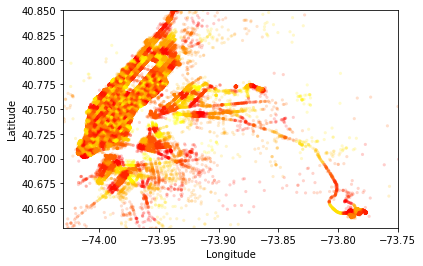

In [9]:
# graph
plt.scatter(training.pickup_longitude.values, training.pickup_latitude.values, s=10, lw=0,  
           c=training.pickup_cluster.values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)  
city_lat_border = (40.63, 40.85)  
plt.xlim(city_long_border)  
plt.ylim(city_lat_border)  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.show()  

# Step3 Add more features into the model

## 3.1 Add **time** as new features into the model

In [10]:
# Extract time in training dataset
training_features = extract_time(training)
# Extract time in testing dataset
testing_features = extract_time(testing)
testing_features.head()

,index,pickup_datetime,travel_time,trip_distance,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance_in_km,...,common_holiday,key_holiday,logrtn,pickup_cluster,dropoff_cluster,pickup_day,pickup_month,pickup_hour,pickup_weekday,log_travel_time
0,197614,2016-05-16 21:12:09,908,1.98,40.768913,-73.985291,40.750263,-74.004883,1,2.646645,...,1,0,0.974898,183,40,16,5,21,1,6.812345
1,422527,2016-02-23 08:07:46,631,1.23,40.776291,-73.961807,40.761127,-73.971237,1,1.861236,...,0,0,-1.253258,478,334,23,2,8,2,6.448889
2,25550,2016-01-23 11:11:56,895,1.80,40.724461,-73.993164,40.745010,-73.978615,1,2.589596,...,0,0,0.000000,267,260,23,1,11,6,6.797940
3,293367,2016-06-27 13:31:47,520,1.10,40.744225,-73.984749,40.755836,-73.983467,2,1.293948,...,0,0,-1.826225,312,86,27,6,13,1,6.255750
4,295712,2016-06-28 22:29:51,587,2.10,40.734615,-74.004715,40.709133,-74.005531,1,2.830502,...,0,0,1.761412,146,71,28,6,22,2,6.376727


# Step4 Convert categorical variables into dummy variables using one hot encode

In [13]:
# Transfrom categorical variables into dummy variables using one hot encode
# training dataset
training_dummy = dummy_one_hot(training_features)
# testing dataset
testing_dummy = dummy_one_hot(testing_features)


In [12]:
# let testing data and training data has the same columns 
training_final = col_consistant(training_dummy,500).drop(['index'],axis=1)
testing_final = col_consistant(testing_dummy,500).drop(['index'],axis=1)
testing_final = testing_final[training_final.columns.values.tolist()]
testing_final.head()


,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,p_10,p_41,p_233
0,2.646645,3.719166,0.919144,11.401331,22.107418,0.812001,4.815708,2.119784,9.460135,21.958553,...,1,0,0,0,0,0,0,0,0,0
1,1.861236,2.476971,2.220561,8.384646,20.495702,3.550141,2.131273,3.901086,7.472309,21.014789,...,0,1,0,0,0,0,0,0,0,0
2,2.589596,3.505980,1.455195,9.448735,19.933859,2.314745,4.024772,2.947907,11.508667,19.850284,...,0,0,0,0,0,1,0,0,0,0
3,1.293948,1.397263,1.036087,9.507240,20.955943,2.371714,3.142566,1.082488,9.964036,20.317391,...,1,0,0,0,0,0,0,0,0,0
4,2.830502,2.898385,4.749289,13.274703,20.126977,3.760951,8.579335,2.030521,11.911581,21.229410,...,0,1,0,0,0,0,0,0,0,0


In [14]:
training_final.head()

,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,p_10,p_41,p_233
0,0.835619,1.093035,3.681307,8.729913,22.290366,4.933625,1.235488,3.129407,9.475959,22.651269,...,0,0,0,0,0,1,0,0,0,0
1,2.331261,2.432333,2.576834,12.283998,21.162931,1.448458,6.628851,0.987388,11.453930,22.208728,...,1,0,0,0,0,0,0,0,0,0
2,3.269653,4.191860,4.059302,13.126579,20.704680,2.976832,8.014222,0.796910,10.859930,21.095372,...,0,0,0,0,0,0,1,0,0,0
3,1.336802,1.696601,0.131764,10.592475,21.384072,1.217170,4.243354,1.463875,11.383583,21.096991,...,0,0,0,0,0,0,1,0,0,0
4,14.672341,15.174844,8.005290,12.677623,15.850484,7.590254,10.692123,7.720675,8.417529,23.943329,...,1,0,0,0,0,0,0,0,0,0


# Step5 Build model

## 5.1 Linear model - LASSO

### 5.1.1 Feature Selection

delete some features that seems like do not have linear association with trip duration

In [16]:
taxi_data_linear = training.drop(['speed', 'pickup_datetime', 
                                'trip_distance', 'drop_CSMK_DISTANCE', 'drop_MMOA_DISTANCE',                           
       'pick_CSMK_DISTANCE', 'pick_LAG_DISTANCE', 'drop_LAG_DISTANCE',
       'pick_MMOA_DISTANCE',  'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 
       'dropoff_longitude', 'rain_drizzle', 'fog', 'snow_ice_pellets', 'hail', 'thunder',
        'pick_PEN_DISTANCE', 'drop_PEN_DISTANCE','pickup_cluster','dropoff_cluster','index','pickup_day',
       'pickup_month', 'pickup_hour', 'pickup_weekday','log_travel_time'] ,axis=1)
test_linear = testing_features.drop(['speed', 'pickup_datetime', 
                                'trip_distance', 'drop_CSMK_DISTANCE', 'drop_MMOA_DISTANCE',                           
       'pick_CSMK_DISTANCE', 'pick_LAG_DISTANCE', 'drop_LAG_DISTANCE',
       'pick_MMOA_DISTANCE',  'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 
       'dropoff_longitude', 'rain_drizzle', 'fog', 'snow_ice_pellets', 'hail', 'thunder',
        'pick_PEN_DISTANCE', 'drop_PEN_DISTANCE','pickup_cluster','dropoff_cluster','index','pickup_day',
       'pickup_month', 'pickup_hour', 'pickup_weekday','log_travel_time','travel_time'] ,axis=1)
test_linear_y = testing_features['travel_time']
taxi_data_linear.columns.values


#给蔡婷  
#前面你不需要的code我都注释了，你跑你的就行。
#你用taxi_data_linear开始你的分析，最后模型预测的时候用test_linear，然后得到结果跟test_linear_y比，输入csv

array(['travel_time', 'passenger_count', 'distance_in_km',
       'Parallel_Distance', 'drop_JFK_DISTANCE', 'pick_JFK_DISTANCE',
       'temp', 'visib', 'wdsp', 'gust', 'max', 'min', 'prcp', 'sndp',
       'common_holiday', 'key_holiday', 'logrtn'], dtype=object)

### 5.1.2 Split the whole data into training and testing, and scale

since there are still many features left, we want to use Lasso model to fit the data and do further feature selection

first, split the whole data into training part and test part and scale them since we will use Lasso model later

In [17]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pylab


Y = taxi_data_linear.travel_time
X = taxi_data_linear.drop(columns = 'travel_time', axis = 1)
#X = X.assign(intercept = np.repeat(1, len(X)))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state =535)

X_scaled_train = (X_train-np.mean(X_train))/np.std(X_train)
y_scaled_train = Y_train - np.mean(Y_train)
X_scaled_test = (X_test-np.mean(X_train))/np.std(X_train)
y_scaled_test = Y_test - np.mean(Y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
X_scaled_train = pd.DataFrame(X_scaled_train)
y_scaled_train = pd.DataFrame(y_scaled_train)
X_scaled_train.columns = X_train.columns
X_scaled_train.head()
#taxi_data_train = X_scaled_train.join(y_scaled_train)
taxi_data_train = pd.merge(X_scaled_train, y_scaled_train, left_index=True, right_index=True)
y_scaled = taxi_data_train.travel_time
X_scaled = taxi_data_train.drop(columns = 'travel_time', axis = 1)

### 5.1.3 Tune the parameter

tune the penalty parameter's value for Lasso model to select the most properly one

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

alphas = [0.1, 1, 5]
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_scaled, y_scaled)
    coefs.append(lasso.coef_)

#cv_params = {'alpha': [0.1, 1]} # try many times to get the best "n_estimators"
#model = Lasso(fit_intercept=False)
#optimized_Lasso = GridSearchCV(estimator=model, param_grid=cv_params
#                            , scoring='r2', cv=3, verbose=3, n_jobs=-1)
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_scaled_train, y_scaled_train)
lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X_scaled_train, y_scaled_train)
print("mse = ",mean_squared_error(y_scaled_test, lasso.predict(X_scaled_test)))
print("best model coefficients:")
pd.Series(lasso.coef_, index=X.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Alpha= 0.0008588989822385325
mse =  174176.46758068373
best model coefficients:


passenger_count        4.543800
distance_in_km       886.904354
Parallel_Distance   -373.409167
drop_JFK_DISTANCE    -14.282495
pick_JFK_DISTANCE     27.325031
temp                  16.991780
visib                 -9.943898
wdsp                  15.458964
gust                   6.080579
max                   -2.690771
min                    9.352741
prcp                  -7.345797
sndp                 -10.808866
common_holiday        -9.450079
key_holiday          -15.287903
logrtn                 4.411021
dtype: float64

### 5.1.4 Fit Model and Predict

#### 5.1.4.1 Fit model

In [66]:
L_model = Lasso(alpha = 0.0008588989822385325, fit_intercept=False)
L_model.fit(X_scaled_train, y_scaled_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.0008588989822385325, copy_X=True, fit_intercept=False,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### 5.1.4.2 Predict
unscale the data so that the prediction is reasonable and put the test y and prediction y together

In [67]:
test_linear_scaled = (test_linear-np.mean(X_train))/np.std(X_train)

In [68]:
y_train_pred = L_model.predict(test_linear_scaled) + np.mean(Y_train)
y_train_pred = pd.DataFrame(y_train_pred)
test_linear_y = pd.DataFrame(test_linear_y)
y_train_pred.columns = ['travel_time_prediction']

y_lasso = pd.merge(test_linear_y, y_train_pred, left_index=True, right_index=True)
np.sqrt(mean_squared_log_error(test_linear_y.values, y_train_pred.values))

0.5321438686510488

In [84]:
y_lasso.to_csv('y_lasso.csv', index = False)

### 5.1.5 Feature Importance

([<matplotlib.axis.YTick at 0x1a1bdf5cf8>,
 <a list of 16 Text yticklabel objects>)

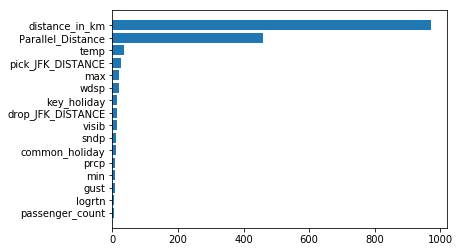

In [83]:
import matplotlib.pyplot as plt
y = abs(L_model.coef_)
coef_ = pd.DataFrame(y)
coef_.columns = ['value']
coef_['coef'] =  X_test.columns
coef_ = coef_.sort_values(ascending=True, by=['value'])

x0 = np.linspace(1,16,16)

plt.barh(x0, coef_.value)
plt.yticks(x0, coef_.coef)

## 5.2 Decision Tree

### 5.2.1 Test train split and using 3 fold cross validation

In [11]:
# Feature selection
# training dataset
training_dummy1 = dummy_one_hot1(training_features)
# testing dataset
testing_dummy1 = dummy_one_hot1(testing_features)
testing_dummy1.head()
# let testing data and training data has the same columns 
training_final1 = col_consistant1(training_dummy1).drop(['index'],axis=1)
testing_final1 = col_consistant1(testing_dummy1).drop(['index'],axis=1)
testing_final1 = testing_final1[training_final1.columns.values.tolist()]

In [12]:
y_train=training_final1['travel_time']
X_train=training_final1.drop('travel_time',1)
## training_final1 是你用来训练模型的～～～～～
X_test = testing_final1.drop('travel_time',1)
y_test = testing_final1['travel_time']
kf = KFold(n_splits=3, shuffle=True, random_state=1111)
kf

KFold(n_splits=3, random_state=1111, shuffle=True)

### 5.2.2 Regularization, Grid Search and tuning parameter

In [13]:
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.square(np.subtract(np.log1p(y_true), np.log1p(y_pred)))))

1.I first try to tuning each parameter individually and get best sample split is 0.1, best depth is 15. best sample_leaf is 5
best max_features is 90.

2.After many trials of different parameters, I choose only to tune max_depth and use default parameters since this will give me a lower msle score.  This parameter indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data.

3.I also tried lots of different parameters and a detailed grid for all parameters are here:


In [ ]:
model = DecisionTreeRegressor()
param_grid = {
    'max_depth': [11, 13, 15, 17, 21, 23] ,
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [0.1,0.2],
    'max_features':  [10,20,30,40,50,60,70,80,90]
}


**The result was:**

**RMSLE = 0.44 for max depth = 11, min_samples_leaf = 3, min_sample_split = 0.1**


Use 3 fold cross validation with grid search method to tune parameters

In [14]:
model = DecisionTreeRegressor()
param_grid = {
    'max_depth' : [11, 13, 15, 17, 21, 23]    
}
search_cv = GridSearchCV(model, param_grid, scoring=make_scorer(rmsle, greater_is_better=False),
                   cv=kf, verbose=3)

search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=11 ....................................................
[CV] .......... max_depth=11, score=-0.4446616010889671, total=  10.2s
[CV] max_depth=11 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] .......... max_depth=11, score=-0.4470023943712959, total=   9.5s
[CV] max_depth=11 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s


[CV] ......... max_depth=11, score=-0.45031179040679803, total=   9.4s
[CV] max_depth=13 ....................................................
[CV] ......... max_depth=13, score=-0.44143186875832935, total=  11.3s
[CV] max_depth=13 ....................................................
[CV] ......... max_depth=13, score=-0.44245580843743754, total=  11.8s
[CV] max_depth=13 ....................................................
[CV] .......... max_depth=13, score=-0.4467947486930407, total=  11.4s
[CV] max_depth=15 ....................................................
[CV] ......... max_depth=15, score=-0.44138310881268006, total=  12.2s
[CV] max_depth=15 ....................................................
[CV] .......... max_depth=15, score=-0.4411892762434818, total=  12.5s
[CV] max_depth=15 ....................................................
[CV] .......... max_depth=15, score=-0.4476208563177184, total=  12.5s
[CV] max_depth=17 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.1min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=1111, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [11, 13, 15, 17, 21, 23]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=3)

### 5.2.3 Performance, importance plot

0.43561827382082646


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,12.340664,0.171208,-0.443398,-0.392625,15,{'max_depth': 15},1,-0.441383,-0.392677,-0.441189,-0.394512,-0.447621,-0.390686,0.144850,0.002861,0.002987,0.001562
1,11.443396,0.168549,-0.443561,-0.414891,13,{'max_depth': 13},2,-0.441432,-0.415452,-0.442456,-0.416160,-0.446795,-0.413061,0.203501,0.007464,0.002325,0.001326
0,9.686428,0.151262,-0.447325,-0.433721,11,{'max_depth': 11},3,-0.444662,-0.434732,-0.447002,-0.433790,-0.450312,-0.432642,0.361930,0.003848,0.002318,0.000855
3,13.382877,0.185837,-0.447863,-0.366018,17,{'max_depth': 17},4,-0.445023,-0.365747,-0.445879,-0.369758,-0.452686,-0.362550,0.149324,0.016933,0.003428,0.002949
4,15.877538,0.212764,-0.466891,-0.302915,21,{'max_depth': 21},5,-0.464979,-0.301014,-0.465166,-0.307446,-0.470526,-0.300285,0.214064,0.016171,0.002572,0.003217


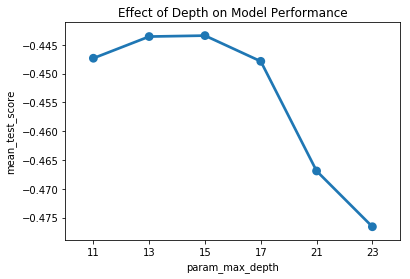

In [18]:
rmsle = {}
for i in (1,2,3,4,5):
    def rmsle1(y, y0):
        return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))
    
    y_pred = search_cv.best_estimator_.predict(X_test)
    rmsle[i] = rmsle1(y_pred,y_test)
print(np.array(list(rmsle.values())).mean())

df1 = pd.DataFrame(data=search_cv.cv_results_)
df1
fig,ax = plt.subplots()
sns.pointplot(data=df1[['mean_test_score',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',ax=ax)
ax.set(title="Effect of Depth on Model Performance")
results = pd.DataFrame(search_cv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

In [16]:
iris = load_iris()
clf = tree.DecisionTreeClassifier(max_depth=15)
clf = clf.fit(X_train,y_train)
fidt = pd.Series(clf.feature_importances_)

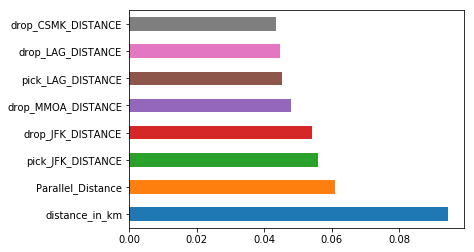

0    0.094425
1    0.061055
9    0.055773
4    0.054085
6    0.047961
8    0.045147
3    0.044644
5    0.043508
dtype: float64


In [25]:
colname = ['distance_in_km','Parallel_Distance','pick_JFK_DISTANCE','drop_JFK_DISTANCE',
 'drop_MMOA_DISTANCE','pick_LAG_DISTANCE','drop_LAG_DISTANCE','drop_CSMK_DISTANCE']
fidt.nlargest(8).plot(kind='barh')
plt.yticks(range(0,8),colname)

plt.show()
print(fidt.nlargest(8))

### 5.2.4 Prediction


In [26]:
new_series = pd.Series(y_pred)
dtree=pd.concat([y_test.reset_index(drop=True), new_series.reset_index(drop=True)], axis=1)
#test.to_csv("C:/Users/59381/Desktop/test.csv", index = False)

## 5.3 XGBoost

**Introdutcion to XGBoost (eXtreme Gradient Boosting)**

XGBoost is an advanced implementation of gradient boosting algorithm. The original author is Tianqi Chen. XGBoost has many parameters and  parameter tuning is complex.

### 5.3.1 Split data into train and test data again

We split the data used to build model again to seperate traning data and validation data.

In [15]:
train, test  = train_test_split(training_final,test_size=0.8, random_state=535)

In [16]:
# train and test dataset for the XGBoost model
X_train = train.drop(['log_travel_time'], axis=1)  
Y_train = train["log_travel_time"]  
X_test = test.drop(['log_travel_time'], axis=1)  
Y_test = test["log_travel_time"]

Y_test = Y_test.reset_index().drop('index',axis = 1)  
Y_train = Y_train.reset_index().drop('index',axis = 1)  
# Testing dataset
X_testing = testing_final.drop(['log_travel_time'], axis=1) 
Y_testing = testing_final["log_travel_time"]  
Y_testing = Y_testing.reset_index().drop('index',axis = 1)  

### 5.3.2 Transfrom training data and testing data into the format that suit for XGBoost 

In [17]:
# Transfrom training data and testing data into the format that suit for XGBoost 
dtrain = xgb.DMatrix(X_train, label=Y_train)  
dvalid = xgb.DMatrix(X_test, label=Y_test)  
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]  
dtest = xgb.DMatrix(X_testing)

### 5.3.3 Tune the model

The overall parameters have been divided into 3 categories by authors:
<br>&emsp;&emsp;*General Parameters:* Guide the overall functioning
<br>&emsp;&emsp;&emsp; 1. booster: It has two options: "gbtree" or "gblinear". We will set it as "gbtree".
<br>&emsp;&emsp;&emsp; 2. slient: It could be 0 or 1. If it is 1, there would be no running message. We will set it as 1.
<br>&emsp;&emsp;*Booster Parameters:* Guide the individual booster (tree/regression) at each step
<br>&emsp;&emsp;&emsp; 1. eta: Step size shrinkage used in update to prevents overfitting. We will tune this parameter later.
<br>&emsp;&emsp;&emsp; 2. max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. We will tune this parameter later.
<br>&emsp;&emsp;&emsp; 3. min_child_weight: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. We will tune this parameter later.
<br>&emsp;&emsp;&emsp; 4. subsample: Subsample ratio of the training instances. This will prevent overfitting We will tune this parameter later.
<br>&emsp;&emsp;*Learning Task Parameters:* Guide the optimization performed
<br>&emsp;&emsp;&emsp; 1. objective: we ues "reg:linear"
<br>&emsp;&emsp;&emsp; 2. eval_metric: we ues "rmse": root mean square error.

We ues some parameters by its default value and will focus on turing 4 booster paramters: *n_estimators*, *eta*, *max_depth*, *min_child_weight*, *subsample* . First of all, beacuse our dataset is super large and the computation ability in laptop is limited. We will first ues a small dataset from training data and find the best parameter using **3 fold cross validation** in the small dataset.

#### 5.3.3.1 Tune *n_eatinators* using **GridSearchCV**

As we could see, we first use **GridSearchCV** to perform 3 fold crossing validation to find the best *n_estimators*. The speed is quite slow using GridSearchCV function. It took over 25 minutes when *n_estimators* from 500 to 800. So we will use **xgb.cv** to tune other parameters on a smaller sample size and then using **GridSearchCV** to get more accurate results.

In [59]:
# split another smaller training dataset to turn the model
training_t, testing_t  = train_test_split(train,test_size=0.6)
X_train_t = training_t.drop(['log_travel_time'], axis=1)  
Y_train_t = training_t["log_travel_time"]  
X_test_t = testing_t.drop(['log_travel_time'], axis=1)  
Y_test_t = testing_t["log_travel_time"]

Y_test_t = Y_test_t.reset_index().drop('index',axis = 1)  
Y_train_t = Y_train_t.reset_index().drop('index',axis = 1)  

# Transfrom training data and testing data into the format that suit for XGBoost 
dtrain_t = xgb.DMatrix(X_train_t, label=Y_train_t)  
dvalid_t = xgb.DMatrix(X_test_t, label=Y_test_t)  
watchlist_t = [(dtrain_t, 'train'), (dvalid_t, 'valid')]  
dtrain_t = xgb.DMatrix(X_train_t, Y_train_t)

In [71]:
from sklearn.model_selection import GridSearchCV
cv_params = {'n_estimators': [80,100,120]} # try many times to get the best "n_estimators"
other_params = {'learning_rate': 0.3, 'n_estimators': 105, 'seed': 0,'max_depth': 6, 'min_child_weight': 35,
                    'subsample': 0.9, 'colsample_bytree': 0.9,  'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params
                             , scoring='r2', cv=3, verbose=3, n_jobs=-1)
optimized_GBM.fit(X_train_t, Y_train_t)
evalute_result = optimized_GBM.grid_scores_
print('Best Parameter：{0}'.format(optimized_GBM.best_params_))
print('R2:{0}'.format(optimized_GBM.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=80 .................................................
[CV] n_estimators=80 .................................................
[CV] n_estimators=80 .................................................
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=80, score=0.7193263279083408, total= 4.4min
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=80, score=0.7139048471375826, total= 4.4min
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=80, score=0.7125370296472929, total= 4.5min
[CV] n_estimators=120 ................................................
[CV] ....... n_estimators=100, score=0.7195233856588205, total= 5.5min
[CV] n_estimators=120 ................................................
[CV] ....... n_estimators=100, score=0.7156352741047635, total= 5.0min
[CV] n_estimators=

[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  9.6min remaining:  4.8min


[CV] ....... n_estimators=120, score=0.7196311033037806, total= 5.8min
[CV] ....... n_estimators=120, score=0.7195830995708823, total= 5.3min
[CV] ....... n_estimators=120, score=0.7116803072913338, total= 3.7min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 13.3min finished


Best Parameter：{'n_estimators': 120}
R2:0.7169649151554455


/Users/xiaoyun/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### 5.3.3.2 Automaticly tune other parameters to get a rough range using xgb.cv

Using  **xgb.cv** to tune *max_depth*, *eta*, *subsample*, *min_child_weight* automaticly.

In [24]:
# automatic find the best parameter using fuctions from random 
# using cross validation to find the best parameter
best_param = list()
best_seednumber = 123
best_rmse = np.Inf
best_rmse_index = 0


for iter in range(20):
    param = {'objective' : "reg:linear",            
                 'max_depth' : np.random.randint(6,8),         
                 'eta' : np.random.uniform(.1, .3),            
                 'subsample' : np.random.uniform(.7, .9),             
                 'min_child_weight' : np.random.randint(1,41),
                 'lambda': 1., 'booster' : 'gbtree', 'silent': 1}
    
    cv_nround = 120                                   
    cv_nfold = 3                                     # 3 fold cross validation
    seed_number = np.random.randint(0,100)
    random.seed(seed_number)
   
    mdcv = xgb.cv(params = param, dtrain=dtrain_t, metrics=["rmse"],
                    nfold=cv_nfold, num_boost_round=cv_nround, verbose_eval = None,
                    early_stopping_rounds=10, maximize=False)

    min_rmse = min(mdcv['test-rmse-mean'])
    min_rmse_index = mdcv.index[mdcv['test-rmse-mean'] == min(mdcv['test-rmse-mean'])][0]

    if min_rmse < best_rmse:
        best_rmse = min_rmse
        best_rmse_index = min_rmse_index
        best_seednumber = seed_number
        best_param = param
        
print('best_round = %d, best_seednumber = %d' %(best_rmse_index,best_seednumber))
print('best_param', best_param)

best_round = 45, best_seednumber = 68
best_param {'objective': 'reg:linear', 'max_depth': 7, 'eta': 0.2950003115062557, 'subsample': 0.8443674314266695, 'min_child_weight': 34, 'lambda': 1.0, 'booster': 'gbtree', 'silent': 1}


#### 5.3.3.3 Tune *max_depth*,  *min_child_weight* using **GridSearchCV**.

In [60]:
from sklearn.model_selection import GridSearchCV
cv_params = {'max_depth': [6, 7], 'min_child_weight': [27,30,33]}

other_params = {'learning_rate': 0.3, 'n_estimators': 120, 'seed': 0,'max_depth': 6, 'min_child_weight': 35,
                    'subsample': 0.8, 'colsample_bytree': 0.9,  'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=3, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train_t, Y_train_t)
evalute_result = optimized_GBM.grid_scores_
print('Best Parameter：{0}'.format(optimized_GBM.best_params_))
print('R2:{0}'.format(optimized_GBM.best_score_))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 33.0min finished


Best Parameter：{'max_depth': 7, 'min_child_weight': 33}
R2:0.74319506742227


/Users/xiaoyun/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### 5.3.4 Use the best parameters to fit the model

In [22]:
xgb_pars = {'min_child_weight': 30, 'eta': 0.3, 'colsample_bytree': 0.9, 
                       'max_depth': 6,
                       'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
                       'eval_metric': 'rmse', 'objective': 'reg:linear'}
xgb_model = xgb.train(xgb_pars, dtrain, 120, watchlist, early_stopping_rounds=10,
                 maximize=False, verbose_eval=10)

[0]	train-rmse:4.22166	valid-rmse:4.221
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:0.42308	valid-rmse:0.431673
[20]	train-rmse:0.376246	valid-rmse:0.389523
[30]	train-rmse:0.36549	valid-rmse:0.38299
[40]	train-rmse:0.357978	valid-rmse:0.378538
[50]	train-rmse:0.352149	valid-rmse:0.376226
[60]	train-rmse:0.344	valid-rmse:0.372395
[70]	train-rmse:0.340499	valid-rmse:0.372588
Stopping. Best iteration:
[62]	train-rmse:0.343344	valid-rmse:0.372207



### 5.3.5  Feature importance plots

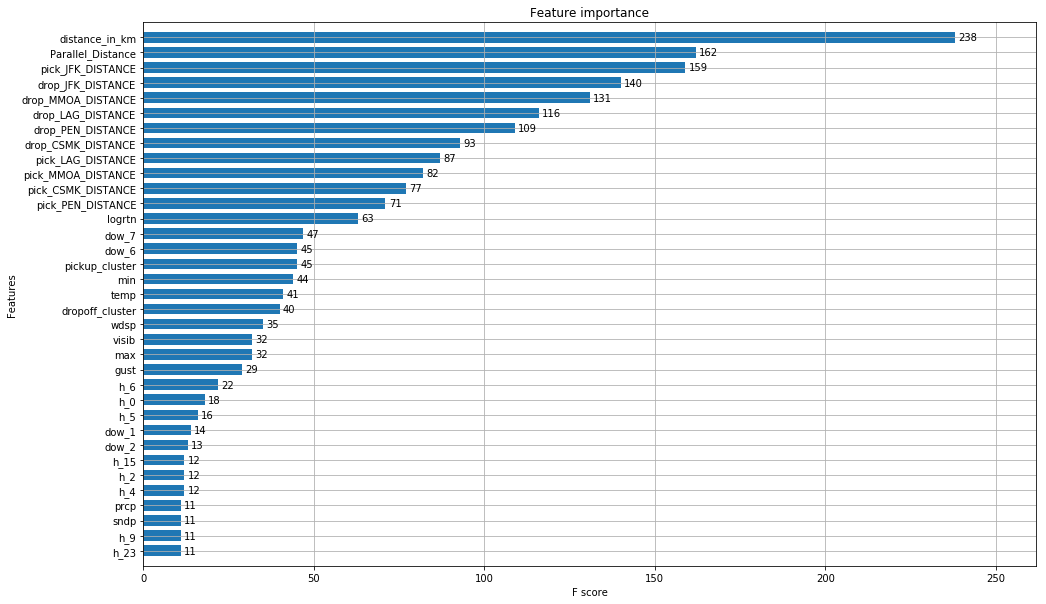

In [23]:
plt.rcParams['figure.figsize'] = [16, 10]
xgb.plot_importance(xgb_model, max_num_features=35, height=0.7)

### 5.3.6 Prediction

In [26]:
# get predicted duration
pred = xgb_model.predict(dtest) 
pred = np.exp(pred) -1
# get real dutation
Y_real =  np.exp(Y_testing) -1

print(np.sqrt(mean_squared_log_error(Y_real, pred )))

0.3673575795688253


When I tune the parameters, I found although tuning parameters could help improve the performance of the model but it could only improve the model a little bit. Adding right features could improve in a more efficient way. 

In [32]:
xgb = pd.concat([Y_real, pd.DataFrame(pred)], axis=1)  
#xgb['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)  
#xgb.to_csv("xgb.csv", index=False)  

## 5.4 Back-Propagation Neural Network 

In this part, we tried to build Back-Propagation(BP) neural network to estimate the duration of taxi trip.

### 5.4.1 Prepare data

In [3]:
def prepare_data(data):
    # drop useless columns
    dataset = data.drop(['date_of_year', 'date_of_year2', 'mo','da','trip_distance','speed'], axis = 1)
    dataset.loc[dataset.Parallel_Distance.isnull(), 'Parallel_Distance'] = dataset[dataset['Parallel_Distance'].isnull()]['distance_in_km'].values
    return dataset
dataset = prepare_data(taxi_data)
# dataset.describe()

### 5.4.2 Transform variables for the model

#### 5.4.2.1 Time
We extracted new two varaibles: hour and weekday from `pickup_datetime`. In terms of EA, these two features have siginificant impact on the taxi trip duration. 

In [4]:
# extracted new two varaibles: hour and weekday
def Extract_Time (data):
    data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)  
    data.loc[:,'pickup_hour'] =  data['pickup_datetime'].dt.hour
    data.loc[:,'pickup_weekday'] =  data['pickup_datetime'].dt.weekday+1
    # as datetime cannot be used directly, drop it
    data = data.drop(['pickup_datetime'], axis = 1)
    return(data)
  
dataset = Extract_Time(dataset)
dataset.head(1)

,travel_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn,pickup_hour,pickup_weekday
0,1770,40.769695,-73.863449,40.746578,-73.996208,1,11.458089,13.735808,0.524982,10.801247,21.271635,0.914609,4.608698,11.175251,0.934677,15.451244,12.351773,8.351602,63.8,10.0,2.8,999.9,82.0,44.1,0.0,999.9,0,0,0,0,0,0,0,0.651973,19,1


#### 2.2 Convert categorical variables to dummy bariables

In [5]:
# Transfrom categorical variables into dummy variables using one hot encode
def Dummy_One_Hot (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_') 
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_hour','pickup_weekday'], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  passenger_count, hour, dow], axis=1)
    
    return(data)

dataset = Dummy_One_Hot(dataset)
dataset.head(1)

,travel_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
0,1770,40.769695,-73.863449,40.746578,-73.996208,11.458089,13.735808,0.524982,10.801247,21.271635,0.914609,4.608698,11.175251,0.934677,15.451244,12.351773,8.351602,63.8,10.0,2.8,999.9,82.0,44.1,0.0,999.9,0,0,0,0,0,0,0,0.651973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [6]:
# dataset.shape

### 5.4.3 Train model
#### 5.4.3.1 Split data
We first splited data into training and testing data (80%, 20%).

In [6]:
train, test  = train_test_split(dataset, test_size=0.2, random_state=535)
def Split_x_y(data):
    X = data.values[:, 1:dataset.shape[1]]
    Y = data.values[:, 0]
    return X, Y
test_x, test_y = Split_x_y(test)

#### 5.4.3.2 Tune Model
In this part, we tried to find proper parameters, such as the number of network layers, nodes on each layer, epochs,  and batch size, by using `GridSearchCV()`.
Here is the param seach range:
```
{'nodes_num': [[256], [256, 128], [512], [128, 256], [128, 512], [512, 128], [128, 256, 64]], 
 'batch_size': [10,50,100],
 'epochs': [30, 50, 100]}
```

In [ ]:
"""
# select a small sample for tune
index = np.random.choice(train.shape[0], 50000, replace=False)
sample=train.values[index]

# split into input (X) and output (Y) variables
X = sample[:, 1:dataset.shape[1]]
Y = sample[:, 0]
X.shape
"""

In [ ]:
# evaluate using 5-fold cross validation
# kfold = KFold(n_splits=5, shuffle=True)
# results = cross_val_score(model, X, Y, cv=kfold)
# print("Result: %.2f (%.2f) MSLE" % (results.mean(), results.std()))

In [ ]:
# Proper Parameters Search
"""
    First Try:
    grid_params = {'nodes_num': [[256], [256, 128],[512],[128, 256]], 'batch_size': [10,50,100], 'epochs': [30, 50, 100]}
    The best param:
    {'batch_size': 50, 'nodes_num': [128, 256]}
"""
# grid_params = {'nodes_num': [[256], [256, 128],[512],[128, 256]], 'batch_size': [10,50,100], 'epochs': [30, 50, 100]}
"""
grid_result = My_GridSearchCV(grid_params, X, Y)
# summarize results
Summary_GridResult(grid_result)
"""

In [ ]:
"""
    Second Try:
    grid_params = {'nodes_num': [[128, 256], [128, 512], [512, 128]]}
    The best param:
    {'batch_size': 50, 'nodes_num': [128, 256]}
"""
# grid_params = {'nodes_num': [128, 256]}
"""
grid_result = My_GridSearchCV(grid_params, X, Y)
# summarize results
Summary_GridResult(grid_result)
"""

In [ ]:
"""
    Third Try:
    grid_params = {'nodes_num': [[128, 256], [128, 256, 64]]}
    The best param:
    {'batch_size': 50, 'nodes_num': [128, 256, 64]}
"""
# grid_params = {'nodes_num': [[128, 256], [128, 256, 64]]}
"""
grid_result = My_GridSearchCV(grid_params, X, Y)
# summarize results
Summary_GridResult(grid_result)
"""

Finally, we decided to make hidden layers as [128, 256, 64], batch_size equal to 50, total epochs equal to 50. Except the output layer, the activation function of all other leayers is Relu. MSLE is the loss function chosen to minimize.

#### 5.4.3.3 Build BP NN
According to the result of GridSearchCv, we used the best parameter to build BP NN. Besides we used `Dropout()` to avoid overfitting.

In [8]:
# Split train into two parts again
train_build, train_valid = train_test_split(train, test_size=0.2, random_state=535)
train_build_x, train_build_y = Split_x_y(train_build)
train_valid_x, train_valid_y = Split_x_y(train_valid)

In [74]:
def Build_Model(input_dim = (dataset.shape[1]-1), nodes_num=[128, 256, 64], 
                lr=0.0008, decay=0.0, dropout = 0.1):
    n = len(nodes_num)
    # create model
    model = Sequential()
    for i in range(n):
        if i == 0:
            model.add(Dense(nodes_num[i], input_dim=input_dim, activation='relu', kernel_initializer='normal'))
            model.add(Dropout(dropout))
        else :
            model.add(Dense(nodes_num[i], activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    # plot model 
    plot_model(model, to_file='../img/model.png', show_shapes=True, show_layer_names=True)
    # set learing rate
    adam = optimizers.Adam(lr=lr, decay=decay)
    # Compile model
    model.compile(loss=losses.mean_squared_logarithmic_error, optimizer=adam, metrics=[rmsle_loss])
    return model
model =  Build_Model()
bp_result = model.fit(train_build_x, train_build_y, validation_data=(train_valid_x, train_valid_y), epochs=50, batch_size=50, verbose=2)

Train on 346844 samples, validate on 86711 samples
Epoch 1/50
 - 45s - loss: 0.3001 - rmsle_loss: 0.3870 - val_loss: 0.2078 - val_rmsle_loss: 0.3434
Epoch 2/50
 - 44s - loss: 0.1987 - rmsle_loss: 0.3319 - val_loss: 0.2002 - val_rmsle_loss: 0.3299
Epoch 3/50
 - 45s - loss: 0.1897 - rmsle_loss: 0.3225 - val_loss: 0.1739 - val_rmsle_loss: 0.3084
Epoch 4/50
 - 45s - loss: 0.1836 - rmsle_loss: 0.3161 - val_loss: 0.1745 - val_rmsle_loss: 0.3064
Epoch 5/50
 - 45s - loss: 0.1799 - rmsle_loss: 0.3125 - val_loss: 0.1733 - val_rmsle_loss: 0.3068
Epoch 6/50
 - 46s - loss: 0.1772 - rmsle_loss: 0.3096 - val_loss: 0.1673 - val_rmsle_loss: 0.2995
Epoch 7/50
 - 45s - loss: 0.1752 - rmsle_loss: 0.3075 - val_loss: 0.1723 - val_rmsle_loss: 0.3065
Epoch 8/50
 - 45s - loss: 0.1733 - rmsle_loss: 0.3057 - val_loss: 0.1756 - val_rmsle_loss: 0.3101
Epoch 9/50
 - 46s - loss: 0.1723 - rmsle_loss: 0.3045 - val_loss: 0.1739 - val_rmsle_loss: 0.3047
Epoch 10/50
 - 45s - loss: 0.1709 - rmsle_loss: 0.3027 - val_loss: 

Here is our final BP NN model.
<img src="../img/model.png">

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'RMSLE_Loss')

Text(0.5, 0, 'Epoch')

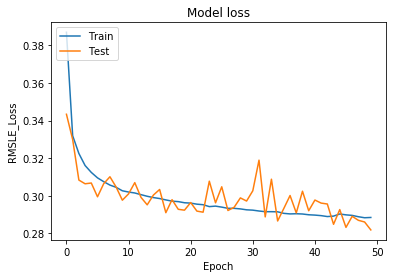

In [76]:
# Plot training & validation loss values
plt.plot(bp_result.history['rmsle_loss'])
plt.plot(bp_result.history['val_rmsle_loss'])
plt.title('Model loss')
plt.ylabel('RMSLE_Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [82]:
# save the model to disk
filename = '../img/finalized_model.h5'
# model.save(filename)

### 5.4.4 Prediction

In [11]:
# load the model from disk with custom objects
# filename = '../img/finalized_model.h5'
filename = 'finalized_model.h5'
loaded_model = load_model(filename , custom_objects={'rmsle_loss': rmsle_loss})

# loaded_model
adam = optimizers.Adam(lr=0.0008)
loaded_model.compile(loss=losses.mean_squared_logarithmic_error, optimizer=adam, metrics=[rmsle_loss])

In [13]:
# predict
y_pred = loaded_model.predict(test_x)

In [15]:
np.sqrt(mean_squared_log_error(test_y, y_pred))

0.3866344918259829

The RMSLE of the prediction on `test` calculated by our final BP NN model is 0.3866.

In [44]:
# Save the result to disk as csv
y = list(x[0] for x in y_pred)
result_dict = {'true_value': test_y, 'prediction': y}
nn = pd.DataFrame(result_dict)

#result.to_csv('NN_pred_result.csv', index = False)

# Step 6 Performance Comparison

## 6.1 Combine the predictions

In [33]:
import os
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans 
import xgboost as xgb
from datetime import datetime  
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [35]:
predictions = pd.concat([bp,xgb["predictions-XGB"]  ,
                          dtree["predictions-decistion tree"],
                          lasso["predictions-lasso"]], axis=1)
predictions.head()

,true_value,predictions-BPNN,predictions-XGB,predictions-decistion tree,predictions-lasso
0,908.0,650.063477,584.07965,771.000000,712.928525
1,631.0,716.676331,723.05096,798.348438,593.960674
2,895.0,741.166199,671.48780,760.395062,661.742954
3,520.0,651.872925,791.06506,681.160045,596.717028
4,587.0,694.319397,724.22720,895.048780,873.868564


## 6.2 Compare RMSLE, RMSE, R2

In [19]:
# 这里的code删除的
xgb = pd.read_csv("xgb.csv") 
xgb = xgb.rename(columns = {'0':'predictions-XGB'})
bp = pd.read_csv("nn.csv") 
bp = bp.rename(columns = {'prediction':'predictions-BPNN'})
dtree = pd.read_csv("dtree.csv") 
dtree = dtree.rename(columns = {'0':'predictions-decistion tree'})
lasso = pd.read_csv("lasso.csv") 
lasso = lasso.rename(columns = {'travel_time_prediction':'predictions-lasso'})

In [58]:
result_compare = modelcompare(xgb,bp,dtree,lasso)
result_compare

,Model,RMSLE,RMSE,R2
0,XGB,0.367358,329.674870,0.752061
1,BP NN,0.386634,344.554001,0.729176
2,Decision Tree,0.435618,385.296722,0.661340
3,Lasso,0.532144,419.219418,0.599082


# Step 7 Important Features

**To conclude, the distance plays a important role in deciding the travel time. Te be more specific, the travel distance and the distance to the main hub of communication: for example, the JFK airport, LaGuardia Airport, Penn station, Metropolitan museum and Chelsea market will determine the length of travel time.**

**Besides of these, from the importance plot of linear model, extreme weather will influence on the duration of travel.**

**From the result of XGboost and decision tree, the log return of stock market also has relation with the travel time.**


## 7.1 Important features in XGboost

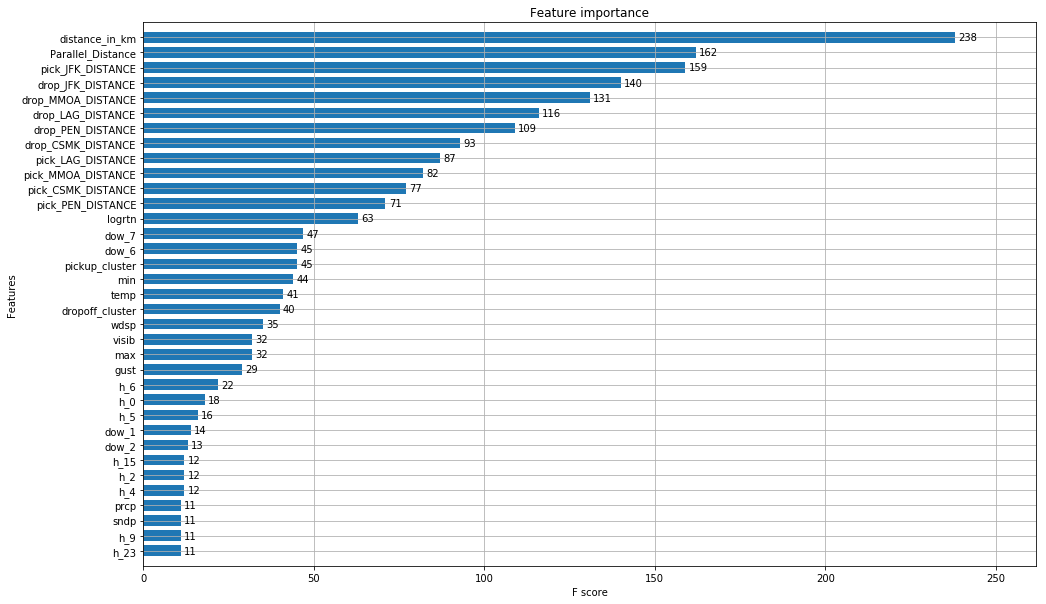

In [23]:
plt.rcParams['figure.figsize'] = [16, 10]
xgb.plot_importance(xgb_model, max_num_features=35, height=0.7)

## 7.2 Important features in Decision Tree

([<matplotlib.axis.YTick at 0x1a1bdf5cf8>,
 <a list of 16 Text yticklabel objects>)

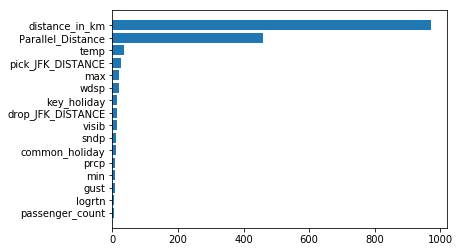

In [83]:
import matplotlib.pyplot as plt
y = abs(L_model.coef_)
coef_ = pd.DataFrame(y)
coef_.columns = ['value']
coef_['coef'] =  X_test.columns
coef_ = coef_.sort_values(ascending=True, by=['value'])

x0 = np.linspace(1,16,16)

plt.barh(x0, coef_.value)
plt.yticks(x0, coef_.coef)

## 7.3 Important features in Lasso 

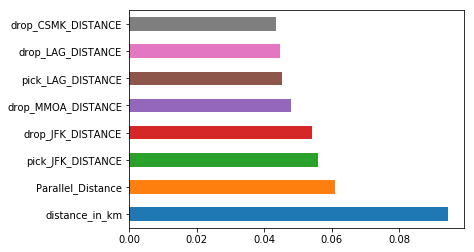

0    0.094425
1    0.061055
9    0.055773
4    0.054085
6    0.047961
8    0.045147
3    0.044644
5    0.043508
dtype: float64


In [25]:
colname = ['distance_in_km','Parallel_Distance','pick_JFK_DISTANCE','drop_JFK_DISTANCE',
 'drop_MMOA_DISTANCE','pick_LAG_DISTANCE','drop_LAG_DISTANCE','drop_CSMK_DISTANCE']
fidt.nlargest(8).plot(kind='barh')
plt.yticks(range(0,8),colname)

plt.show()
print(fidt.nlargest(8))

# Step 8 Extra interesting ideas

**Stock prices is influenced by many factors that includes**
<br>&emsp;&emsp;**1. Overall performance of the company.**
<br>&emsp;&emsp; **2. General environment** 
<br>&emsp;&emsp;**3. Energy market**

**Since NYC is a global hub of finance, these factors may also influence on how people live so we decide to add this factor as a comprehensive factor for duration.**